In [1]:
from keypoint_network import (build_kpextractor64, 
                              build_kpextractor128, 
                              build_kpextractor128_decoupled,
                              build_kpextractor128_decoupled_stn,
                              preproc_dataset)
from train_utils import load_dataset, dataset_loc
import theano.tensor as T
from theano import function as tfn
import cPickle as pickle
import numpy as np
import time
import lasagne.layers as ll
from os.path import join

Couldn't import dot_parser, loading of dot files will not be possible.

+------

<!!! WARNING !!!>
[!custom_layers] WARNING: GPU seems unavailable
<type 'exceptions.ImportError'>: No module named pylearn2.sandbox.cuda_convnet.filter_acts
</!!! WARNING !!!>

L______

Trying /home/zach/envs/thesis/local/lib/python2.7/site-packages/flann-1.8.4-py2.7.egg/pyflann/lib/libflann.so


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)
/home/zach/envs/thesis/local/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [2]:
model_loc = 'all_kpts_128_fixedx'
dset_loc = 'all_kpts_128_fixedx'

In [3]:
#model_name = 'ep1k_alpha_2e-3_lr_1e-2_decoupled.pkl'
model_name = 'model.pkl'
with open(join(dataset_loc, "Flukes/kpts/%s" % join(model_loc, model_name)), 'r') as f:
    model = pickle.load(f)

dset = load_dataset(join(dataset_loc, "Flukes/kpts/%s" % dset_loc), normalize_method='zscore')

Loading /home/zach/data/Flukes/kpts/all_kpts_128_fixedx
Took 7.53 seconds


In [4]:
X = T.tensor4()


kpextractor = build_kpextractor128_decoupled_stn()
ll.set_all_param_values(kpextractor, model)
model_outputs = [ll.get_output(intr_layer, X, deterministic=True) for intr_layer in ll.get_all_layers(kpextractor)]
#segmenter_out = ll.get_output(segmenter, X, deterministic=True)
kpextractor_fn = tfn([X], model_outputs)

dset_for_model = {section:preproc_dataset(dset[section]) for section in ['train', 'valid', 'test']}

point_outputs = {sec:kpextractor_fn(dset_for_model[sec]['X']) for sec in ['train','valid','test']}

In [5]:
list(enumerate(zip([(np.linalg.norm(i), i.shape) for i in ll.get_all_param_values(kpextractor)],ll.get_all_params(kpextractor))))

[(0, ((2.8471589, (8, 1, 3, 3)), loc_conv1.W)),
 (1, ((0.38838664, (8,)), loc_conv1.b)),
 (2, ((0.28841981, (8,)), loc_bn1.beta)),
 (3, ((2.4134927, (8,)), loc_bn1.gamma)),
 (4, ((1.1680485, (8,)), loc_bn1.mean)),
 (5, ((8.0061016, (8,)), loc_bn1.inv_std)),
 (6, ((4.099288, (16, 8, 3, 3)), loc_conv2.W)),
 (7, ((0.23407547, (16,)), loc_conv2.b)),
 (8, ((0.26700473, (16,)), loc_bn2.beta)),
 (9, ((3.4103866, (16,)), loc_bn2.gamma)),
 (10, ((2.5690808, (16,)), loc_bn2.mean)),
 (11, ((5.1346583, (16,)), loc_bn2.inv_std)),
 (12, ((39.247555, (16384, 1024)), loc_fc1.W)),
 (13, ((0.084296957, (1024,)), loc_fc1.b)),
 (14, ((0.224029, (1024,)), loc_bn_fc1.beta)),
 (15, ((27.18811, (1024,)), loc_bn_fc1.gamma)),
 (16, ((32.158836, (1024,)), loc_bn_fc1.mean)),
 (17, ((147.78268, (1024,)), loc_bn_fc1.inv_std)),
 (18, ((17.637318, (1024, 256)), loc_fc2.W)),
 (19, ((0.12835361, (256,)), loc_fc2.b)),
 (20, ((1.7559453, (256,)), loc_bn_fc2.beta)),
 (21, ((12.672418, (256,)), loc_bn_fc2.gamma)),
 (22, ((

In [6]:
[(ind, i.shape[1:], np.average(np.std(i,axis=0)), l.name) for (ind, i), l in zip(enumerate(point_outputs['valid']),ll.get_all_layers(kpextractor))]

[(0, (1, 128, 128), 0.8927716, 'input'),
 (1, (8, 128, 128), 0.32410595, 'loc_conv1'),
 (2, (8, 64, 64), 0.40041202, 'loc_mp1'),
 (3, (8, 64, 64), 0.77348042, 'loc_bn1'),
 (4, (16, 64, 64), 0.53955758, 'loc_conv2'),
 (5, (16, 32, 32), 0.73553097, 'loc_mp2'),
 (6, (16, 32, 32), 0.76424277, 'loc_bn2'),
 (7, (1024,), 1.269942, 'loc_fc1'),
 (8, (1024,), 1.1124767, 'loc_bn_fc1'),
 (9, (256,), 0.29989338, 'loc_fc2'),
 (10, (256,), 0.85441262, 'loc_bn_fc2'),
 (11, (6,), 0.26812884, 'loc_M'),
 (12, (1, 128, 128), 0.95838904, 'stn'),
 (13, (16, 128, 128), 0.49288699, 'conv1'),
 (14, (16, 64, 64), 0.52485836, 'mp1'),
 (15, (16, 64, 64), 0.80588377, 'bn1'),
 (16, (32, 64, 64), 0.73721039, 'conv2'),
 (17, (32, 32, 32), 0.87175506, 'mp2'),
 (18, (32, 32, 32), 0.81246412, 'bn2'),
 (19, (64, 32, 32), 0.71610922, 'conv3'),
 (20, (64, 16, 16), 0.88235694, 'mp3'),
 (21, (64, 16, 16), 0.81291187, 'bn3'),
 (22, (128, 16, 16), 0.63617229, 'conv4'),
 (23, (128, 8, 8), 0.8017593, 'mp4'),
 (24, (128, 8, 8), 0

In [7]:
print(np.std(point_outputs['valid'][11],axis=0))

[ 0.07146408  0.30705962  0.37498793  0.32736257  0.14771402  0.3801848 ]


/home/zach/data/Flukes/Flukebook/images/extract84ae0dd0-a0da-4d94-aa4a-f1b75b1ec61d.jpg
(273, 960)
[[  52.5         14.9296875]
 [ 937.5         29.859375 ]
 [ 450.         191.953125 ]]
[[   7.    7.]
 [ 125.   14.]
 [  60.   90.]]
[[  56.06409836   11.32444477]
 [ 933.10015869   12.51709747]
 [ 448.31112671  191.72053528]]
[[   7.47521305    5.30962992]
 [ 124.41335297    5.8688221 ]
 [  59.77481842   89.89094543]]
[  5.0695734   17.89170647   1.70481408]
[ 1.75589824  8.15231323  0.2501992 ]
[[ 0.96261102  0.58179951  0.00097829]
 [ 0.66952586  0.89103174  0.001324  ]]


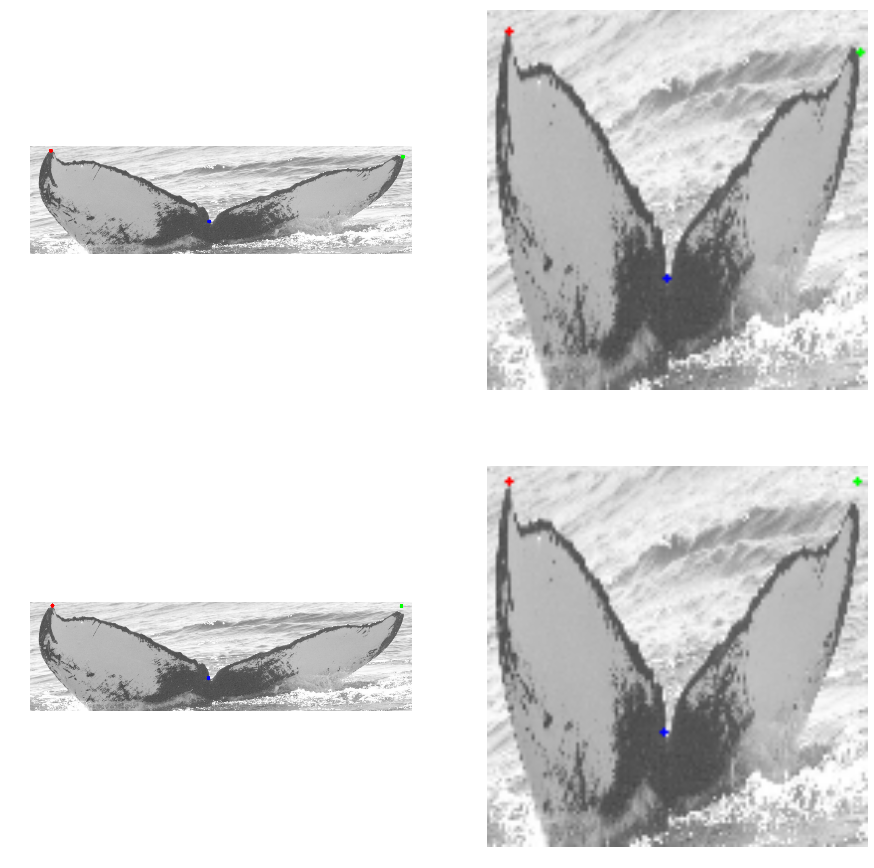

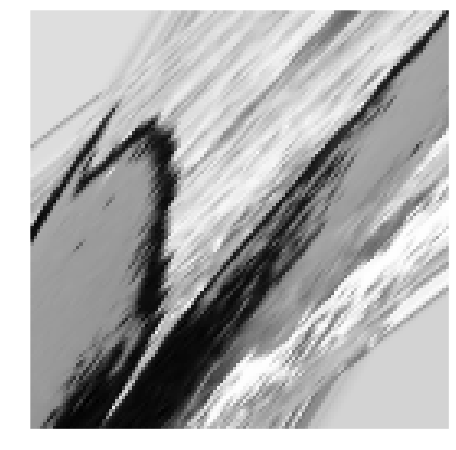

In [24]:
import matplotlib.pyplot as plt
import cv2
import random
%matplotlib inline

def drawPoints(points, img, radius=5):
    color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    cv2.circle(color_img, (int(points[0,0]), int(points[0,1])), radius, (255,0,0), -1) # left
    cv2.circle(color_img, (int(points[1,0]), int(points[1,1])), radius, (0,255,0), -1) # right
    cv2.circle(color_img, (int(points[2,0]), int(points[2,1])), radius, (0,0,255), -1) # notch
    return color_img

def show_output(originals, true_labels, outputs, ind, stage=-1, imgnames=None, sizes=None):
    # the [0] indexes into the channel
    dset_img = ((originals[ind][0]*dset['std']) + dset['mean']).astype(np.uint8)
    dsety, dsetx = dset_img.shape[:2]
    true_points = true_labels[ind]
    imgname = imgnames[ind]
    print(imgname)
    original_img = cv2.cvtColor(cv2.imread(imgname),cv2.COLOR_BGR2GRAY)
    if sizes is not None:
        original_img = cv2.resize(original_img, tuple(sizes[ind][::-1]), cv2.INTER_LANCZOS4)
    print(original_img.shape)
    origy, origx = original_img.shape[:2]
    #sizey, sizex = original.shape[-2:]
    sizey, sizex = (1.,1.)
    scale_denom = np.array([sizex, sizey]*3,dtype=np.float32).reshape(3,2)
    scale_num_orig = np.array([origx, origy]*3,dtype=np.float32).reshape(3,2)
    scale_num_dset = np.array([dsetx, dsety]*3,dtype=np.float32).reshape(3,2)
    true_points_orig = true_points * (scale_num_orig / scale_denom)
    true_points_dset = true_points * (scale_num_dset / scale_denom)
    print(true_points_orig)
    print(true_points_dset)
    #true_points_scaled = (true_points * scale_mat + scale_mat) / 2 
    # draw left right notch on the original image
    orig_gt_drawn = drawPoints(true_points_orig, original_img)
    dset_gt_drawn = drawPoints(true_points_dset, dset_img, radius=1)
    
    pred_points = outputs[-1][ind]
    #pred_points_scaled = (pred_points * scale_mat + scale_mat) / 2
    pred_points_orig = pred_points * (scale_num_orig / scale_denom)
    pred_points_dset = pred_points * (scale_num_dset / scale_denom)
    print(pred_points_orig)
    print(pred_points_dset)
    pred_drawn_orig = drawPoints(pred_points_orig, original_img)
    pred_drawn_dset = drawPoints(pred_points_dset, dset_img, radius=1)
    print(np.linalg.norm(true_points_orig - pred_points_orig, axis=1))
    print(np.linalg.norm(true_points_dset - pred_points_dset, axis=1))
    network_stage = outputs[stage][ind].swapaxes(0,2)
    #print(output)
    f, trueax = plt.subplots(2,2, figsize=(15,15))
    for i in trueax.flatten():
        i.axis('off')
    trueax[0,0].imshow(orig_gt_drawn)
    trueax[0,1].imshow(dset_gt_drawn)
    trueax[1,0].imshow(pred_drawn_orig)
    trueax[1,1].imshow(pred_drawn_dset)
    
    nfilters = network_stage.shape[-1]
    #print(nfilters)
    square_size = int(np.sqrt(nfilters) + 0.5)
    #print(square_size)
    plt.gray()
    if square_size > 1:
        f, netax = plt.subplots(square_size, square_size, figsize=(15,15))
        for i in range(square_size*square_size):
            #netax.set_gray()
            this_ax = netax[i // square_size, i % square_size]
            this_ax.axis('off')
            #this_ax.get_xaxis().set_visible(False)
            #this_ax.get_yaxis().set_visible(False)
            if i < nfilters:
                this_ax.imshow(network_stage[:,:,i].T, interpolation='none')
    else:
        # probably an input or stn
        #print(network_stage[:,:,0])
        print(outputs[stage-1][ind].reshape(2,3))
        denormed =  (dset['std']*network_stage[:,:,0] + dset['mean']).astype(np.uint8).T
        #denormed = network_stage[:,:,0].astype(np.uint8)
        #print(denormed)

        f, netax = plt.subplots(1, figsize=(7.5,7.5))
        netax.axis('off')
        netax.imshow(denormed, interpolation='none')
    #ax[2].imshow(network_stage)

sec = 'train'
show_output(dset_for_model[sec]['X'], dset_for_model[sec]['y'], point_outputs[sec], 
            random.choice(range(dset_for_model[sec]['X'].shape[0])), stage=12, 
            imgnames=dset_for_model[sec]['names'], sizes=dset_for_model[sec]['extra'])

[[ 0.05985688  0.12751727]
 [ 0.92994821  0.12829041]
 [ 0.49307755  0.51545417]]
[[ 0.06060513  0.12197343]
 [ 0.93349683  0.12671399]
 [ 0.49318016  0.51290715]]
0.0438477
0.0784416
0.0900679


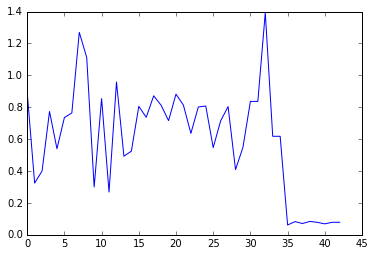

In [9]:
#print(len(point_outputs_valid))
n_layers = len(point_outputs[sec])
#plt.yscale('log')
plt.plot([np.average(np.std(point_outputs[sec][i],axis=0)) for i in range(n_layers)])
avg_prediction = np.average(dset_for_model[sec]['y'],axis=0)
print(avg_prediction)
print(np.average(point_outputs[sec][-1],axis=0))
def eucl_loss(pred, y):
    return np.average(np.linalg.norm(pred - y, axis=2),axis=(0,1))

print(eucl_loss(point_outputs[sec][-1], dset_for_model[sec]['y']))
print(np.average(np.std(point_outputs[sec][-1],axis=0)))
print(np.average(np.std(dset_for_model[sec]['y'],axis=0)))

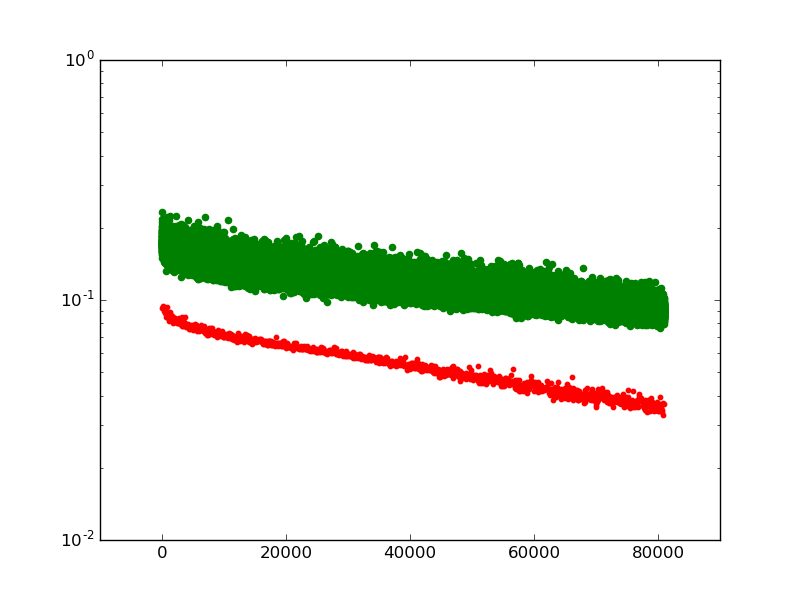

In [10]:
from IPython.display import Image 
Image(filename='./losses.png')

In [11]:
# let's see the worst cases by original size
sec = 'train'
def get_gt_dist(true_pt, pred_pt, sizes):
    #sizey, sizex = (1.,1.)
    sizes = sizes[:,::-1]
    #scale_denom = np.array([sizex, sizey]*3,dtype=np.float32).reshape(3,2)
    scale_num_orig = np.stack([sizes, sizes, sizes],axis=1).astype(np.float32)
    #scale_num_dset = np.array([dsetx, dsety]*3,dtype=np.float32).reshape(3,2)
    true_points_orig = true_pt * (scale_num_orig)
    #true_points_dset = true_points * (scale_num_dset / scale_denom)
    pred_points_orig = pred_pt * (scale_num_orig)
    dists = np.linalg.norm(true_points_orig - pred_points_orig, axis=2)
    #print(dists)
    return dists

gt_dists = get_gt_dist(dset_for_model[sec]['y'], point_outputs[sec][-1], dset_for_model[sec]['extra'])

In [12]:
sorted_by_dist = sorted(zip(gt_dists, list(range(dset_for_model[sec]['X'].shape[0]))), key=lambda x: np.average(x[0]))
dists, ind_sorted = zip(*sorted_by_dist)
sorted_X = dset_for_model[sec]['X'][ind_sorted,:]
sorted_y = dset_for_model[sec]['y'][ind_sorted,:]
sorted_pred = [stage[ind_sorted,:] for stage in point_outputs[sec]]
sorted_names = [dset_for_model[sec]['names'][ind] for ind in ind_sorted]
sorted_sizes = dset_for_model[sec]['extra'][ind_sorted,:]

In [13]:
show_output(sorted_X, sorted_y, sorted_pred, -20, stage=10, imgnames=sorted_names, sizes=sorted_sizes)

/home/zach/data/Flukes/Flukebook/images/extracta9a1c9ce-5457-4f10-bb2e-8daf077eb190.jpg
(1136, 960)
[[  67.5     26.625]
 [ 847.5     26.625]
 [ 547.5    213.   ]]
[[   9.    3.]
 [ 113.    3.]
 [  73.   24.]]
[[  29.67147446   44.08811569]
 [ 909.87701416   48.0217514 ]
 [ 499.88256836  332.10354614]]
[[   3.95619655    4.96767521]
 [ 121.31693268    5.41090155]
 [  66.65100861   37.42011642]]
[  41.66482544   65.94477081  128.26953125]
[  5.41402769   8.65931988  14.84618473]


ValueError: bad axis2 argument to swapaxes

In [ ]:
plt.scatter(range(np.vstack(dists).shape[0]),np.average(np.vstack(dists),axis=1))

In [ ]:
# Export model params and dataset so that IBEIS can use it
model_ibs = {'params':model, 'mean':dset['mean'], 'std':dset['std']}
model_name = 'kpextractor_weights.pkl'
model_dir = '/home/zach/data'
with open(join(model_dir, model_name), 'w') as f:
    pickle.dump(model_ibs, f)
print(model_ibs['mean'])

In [ ]:
M = np.eye(3, dtype=np.float32)[:-1,:] + 0.5
test_img = dset['std']*dset_for_model[sec]['X'][0][0] + dset['mean']
plt.imshow(cv2.warpAffine(test_img, M, (128,128), 0, 0, cv2.BORDER_REPLICATE))